# Import

In [ ]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [ ]:
%cd '/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM'

/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM


In [ ]:
# load and process data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/All_data_final.csv')#,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

dataset
dataset.columns = ['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain', 'lat', 'lon']
dataset.set_index('date', inplace=True)
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print(dataset.columns)
print("||"*40)
dataset.to_csv('pollution_all.csv')

from google.colab import files
files.download("pollution_all.csv")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
               pollution  dew  temp  press  ...  wnd_spd  rain        lat        lon
date                                        ...                                     
1/1/2015 0:00        5.7 -3.6   4.7    0.5  ...      1.4   0.0  36.997444 -121.99676
1/2/2015 0:00        8.1  0.7   5.2    0.6  ...      1.5   0.0  36.997444 -121.99676
1/3/2015 0:00        8.9  0.7   6.5    0.6  ...      1.4   0.0  36.997444 -121.99676
1/4/2015 0:00        8.8  3.1   8.0    0.8  ...      1.3   0.0  36.997444 -121.99676
1/5/2015 0:00        8.3  3.3  12.0    0.8  ...      1.4   0.0  36.997444 -121.99676

[5 rows x 9 columns]
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain',
       'lat', 'lon'],
      dtype='object')
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Lets normalize all features, and remove the weather variables for the day to be predicted.
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def s_to_super(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
dataset = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/pollution_all.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = s_to_super(scaled, 1, 1)

In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# Number of data points
print(len(reframed))

5423


In [ ]:
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
# 5423 data points, so .7 =3796
n_train_days = 3796
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [ ]:
print(n_train_days)
print(train.shape)
print(test.shape)

3796
(3796, 10)
(1627, 10)


In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (3796, 1, 9) (3796,)  Testing data shape X, y =>  (1627, 1, 9) (1627,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# defining LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
model = Sequential()

Epoch 1/50
53/53 - 1s - loss: 0.1286 - val_loss: 0.0028
Epoch 2/50
53/53 - 0s - loss: 0.0026 - val_loss: 0.0035
Epoch 3/50
53/53 - 0s - loss: 0.0019 - val_loss: 0.0028
Epoch 4/50
53/53 - 0s - loss: 0.0019 - val_loss: 0.0028
Epoch 5/50
53/53 - 0s - loss: 0.0018 - val_loss: 0.0027
Epoch 6/50
53/53 - 0s - loss: 0.0018 - val_loss: 0.0027
Epoch 7/50
53/53 - 0s - loss: 0.0018 - val_loss: 0.0027
Epoch 8/50
53/53 - 0s - loss: 0.0018 - val_loss: 0.0026
Epoch 9/50
53/53 - 0s - loss: 0.0018 - val_loss: 0.0026
Epoch 10/50
53/53 - 0s - loss: 0.0017 - val_loss: 0.0026
Epoch 11/50
53/53 - 0s - loss: 0.0017 - val_loss: 0.0025
Epoch 12/50
53/53 - 0s - loss: 0.0017 - val_loss: 0.0025
Epoch 13/50
53/53 - 0s - loss: 0.0017 - val_loss: 0.0024
Epoch 14/50
53/53 - 0s - loss: 0.0016 - val_loss: 0.0024
Epoch 15/50
53/53 - 0s - loss: 0.0016 - val_loss: 0.0023
Epoch 16/50
53/53 - 0s - loss: 0.0016 - val_loss: 0.0023
Epoch 17/50
53/53 - 0s - loss: 0.0016 - val_loss: 0.0022
Epoch 18/50
53/53 - 0s - loss: 0.0015 - 

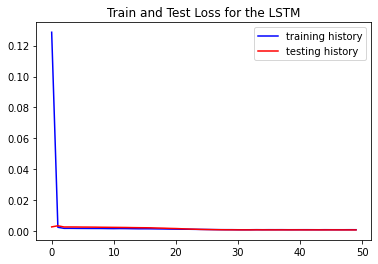

In [ ]:
# Layers
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()

# evaluating model
# make a prediction
from math import sqrt
from numpy import concatenate
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.696


# Saving Model

All models are saved in the folder saved_model in the Forecasting folder

1. saved 'initial_model_one'
2. saved 'sc_test'  --> this is the model using the same baseline as the github respository but with data for Santa Cruz from 2015-2019
3. saved 'all_v1' --> 1 layer; 50 neurons; loss=mean absolute error; dropout=.3
4. saved 'all_v2' --> 1 layer; 100 neurons; loss=mean absolute error; dropout=.4
5. Saved 'all_v3' --> 2 layers; 50 neurons/layer; loss=mean squared error; dropout=.4
6. Saved 'all_v4' --> 3 layers; 100 neurons/layer; loss=mean squared error; dropout=.4

In [ ]:
%cd '/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/saved_model'

/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/saved_model


In [ ]:
# Save the entire model as a SavedModel.
model.save('all_v4')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: all_v4/assets


# Load Saved Model

See Saved models to load in previous section

In [ ]:
%cd '/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/saved_model'

/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/saved_model


In [ ]:
# Update with the model you want to load
model_selection = 'all_v4'

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model(model_selection)

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 44,101
Trainable params: 44,101
Non-trainable params: 0
_________________________________________________________________


# Results

In [ ]:
def plot_predicted(predicted_data, true_data):
    fig, ax = pyplot.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 50 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    pyplot.legend()
    pyplot.show()

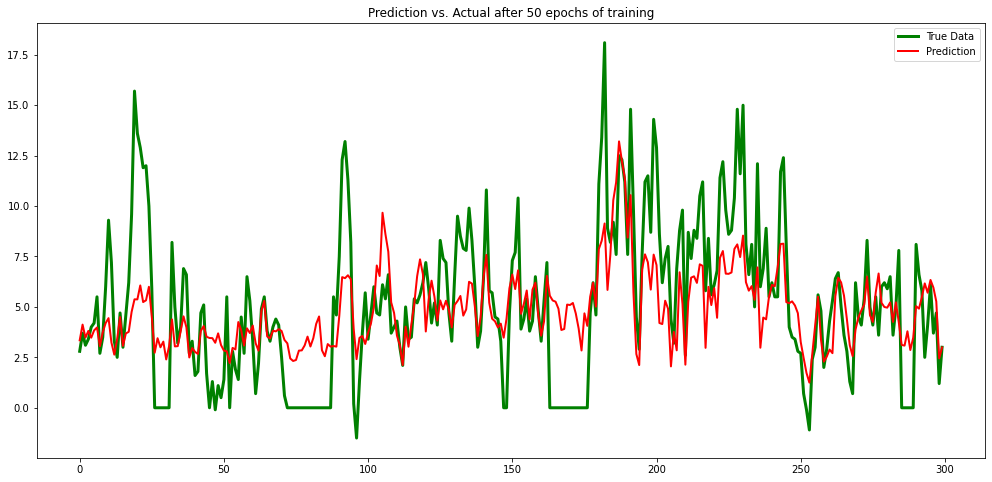

In [ ]:
plot_predicted(inv_yhat[:300,], inv_y[:300,])

# Predictions

Using data from other locations to test model predictions. Data used from Oakland, Napa, and Richmond.

## Oakland

In [ ]:
oakland = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/oakland test.csv')
oakland.columns = ['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain', 'lat', 'lon']
oakland.set_index('date', inplace=True)
oakland.index.name = 'date'
oakland['pollution'].fillna(0, inplace=True)
#dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(oakland.head(5))
print(oakland.columns)
print("||"*40)
oakland.to_csv('pollution_oakland.csv')

from google.colab import files
files.download("pollution_oakland.csv")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
          pollution   dew  temp  press  ...  wnd_spd  rain        lat         lon
date                                    ...                                      
6/3/2018       14.7   5.0  12.2    0.9  ...      1.4   0.0  37.743065 -122.169935
6/4/2018       10.0   4.3  13.9    0.8  ...      1.8   0.1  37.743065 -122.169935
6/4/2018       10.0  10.3  13.9    1.3  ...      2.1   2.7  37.743065 -122.169935
6/5/2018        8.6   9.7  12.0    1.2  ...      1.9   0.0  37.743065 -122.169935
6/5/2018        8.6  10.0  11.7    1.2  ...      1.2   0.0  37.743065 -122.169935

[5 rows x 9 columns]
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain',
       'lat', 'lon'],
      dtype='object')
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
oakland = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/pollution_oakland.csv', header=0, index_col=0)
values2 = oakland.values
encoder = preprocessing.LabelEncoder()
values2[:,4] = encoder.fit_transform(values2[:,4])
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler.fit_transform(values2)
reframed2 = s_to_super(scaled2, 1, 1)

In [ ]:
reframed2.drop(reframed2.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
values2 = reframed2.values
X, Y = values2[:, :-1], test[:, -1]
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

In [ ]:
oakland_pred = model.predict(X)
X = X.reshape((X.shape[0], X.shape[2]))
inv_yhat2 = concatenate((oakland_pred, X[:, 1:]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
inv_y2 = scaler.inverse_transform(X)
inv_y2 = inv_y2[:,0]

In [ ]:
len(inv_yhat2)

650

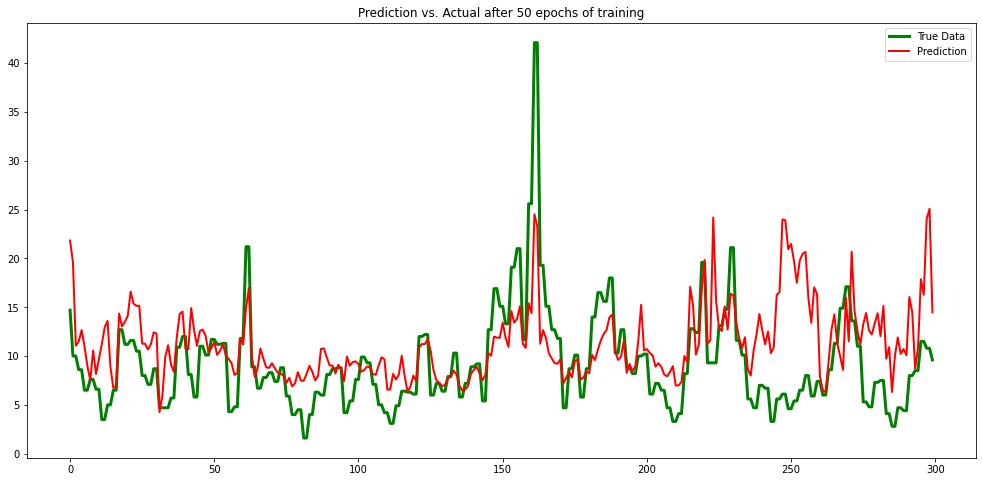

In [ ]:
plot_predicted(inv_yhat2[:300,], inv_y2[:300,])

### Napa

In [ ]:
napa = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/Napa_test.csv')
napa.columns = ['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain', 'lat', 'lon']
napa.set_index('date', inplace=True)
napa.index.name = 'date'
napa['pollution'].fillna(0, inplace=True)
#dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(napa.head(5))
print(napa.columns)
print("||"*40)
napa.to_csv('pollution_napa.csv')

from google.colab import files
files.download("pollution_napa.csv")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
          pollution   dew  temp  press  ...  wnd_spd   rain        lat         lon
date                                    ...                                       
4/2/2018        7.1   9.2  13.0    1.2  ...      0.7   0.00  38.278849 -122.275024
4/3/2018       10.1   9.4  12.2    1.2  ...      1.3   0.00  38.278849 -122.275024
4/4/2018        7.6   9.1  12.8    1.2  ...      1.0   0.00  38.278849 -122.275024
4/5/2018        6.2  10.6  12.8    1.3  ...      1.0   6.35  38.278849 -122.275024
4/6/2018        3.5   NaN  14.8    1.7  ...      0.8  61.21  38.278849 -122.275024

[5 rows x 9 columns]
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain',
       'lat', 'lon'],
      dtype='object')
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
napa = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/pollution_napa.csv', header=0, index_col=0)
values2 = napa.values
encoder = preprocessing.LabelEncoder()
values2[:,4] = encoder.fit_transform(values2[:,4])
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler.fit_transform(values2)
reframed2 = s_to_super(scaled2, 1, 1)

In [ ]:
reframed2.drop(reframed2.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
values2 = reframed2.values
X, Y = values2[:, :-1], test[:, -1]
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

In [ ]:
napa_pred = model.predict(X)
X = X.reshape((X.shape[0], X.shape[2]))
inv_yhat2 = concatenate((napa_pred, X[:, 1:]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
inv_y2 = scaler.inverse_transform(X)
inv_y2 = inv_y2[:,0]

In [ ]:
len(inv_yhat2)

596

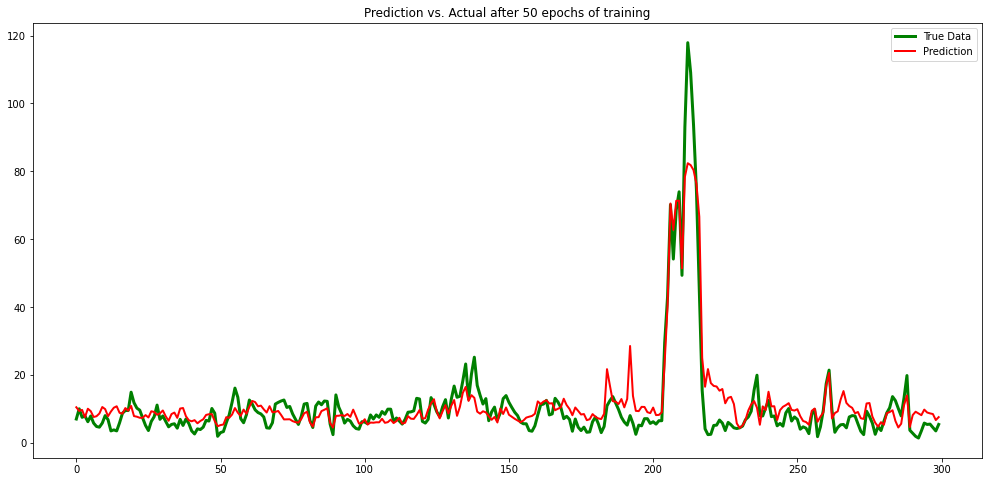

In [ ]:
plot_predicted(inv_yhat2[:300,], inv_y2[:300,])

### Richmond

In [ ]:
rich = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/Richmond_data_final.csv')
rich.columns = ['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain', 'lat', 'lon']
rich.set_index('date', inplace=True)
rich.index.name = 'date'
rich['pollution'].fillna(0, inplace=True)
#dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(rich.head(5))
print(rich.columns)
print("||"*40)
rich.to_csv('pollution_rich.csv')

from google.colab import files
files.download("pollution_rich.csv")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
               pollution   dew  temp  ...  rain        lat         lon
date                                  ...                             
1/1/2018 0:00       18.2   6.7  12.8  ...   0.0  37.931539 -122.302714
1/2/2018 0:00       19.2   4.0  14.3  ...   0.0  37.931539 -122.302714
1/3/2018 0:00       36.6   7.0  13.8  ...   5.6  37.931539 -122.302714
1/4/2018 0:00       32.2  12.3  13.7  ...   1.1  37.931539 -122.302714
1/5/2018 0:00        6.1  13.3  13.3  ...   8.3  37.931539 -122.302714

[5 rows x 9 columns]
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'rain',
       'lat', 'lon'],
      dtype='object')
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rich = pd.read_csv('/content/drive/My Drive/CS230 Project/Model/Forecasting-on-Air-pollution-with-RNN-LSTM/Data/pollution_rich.csv', header=0, index_col=0)
values2 = rich.values
encoder = preprocessing.LabelEncoder()
values2[:,4] = encoder.fit_transform(values2[:,4])
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler.fit_transform(values2)
reframed2 = s_to_super(scaled2, 1, 1)

In [ ]:
reframed2.drop(reframed2.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
values2 = reframed2.values
X, Y = values2[:, :-1], test[:, -1]
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

In [ ]:
rich_pred = model.predict(X)
X = X.reshape((X.shape[0], X.shape[2]))
inv_yhat2 = concatenate((rich_pred, X[:, 1:]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
inv_y2 = scaler.inverse_transform(X)
inv_y2 = inv_y2[:,0]

In [ ]:
len(inv_yhat2)

354

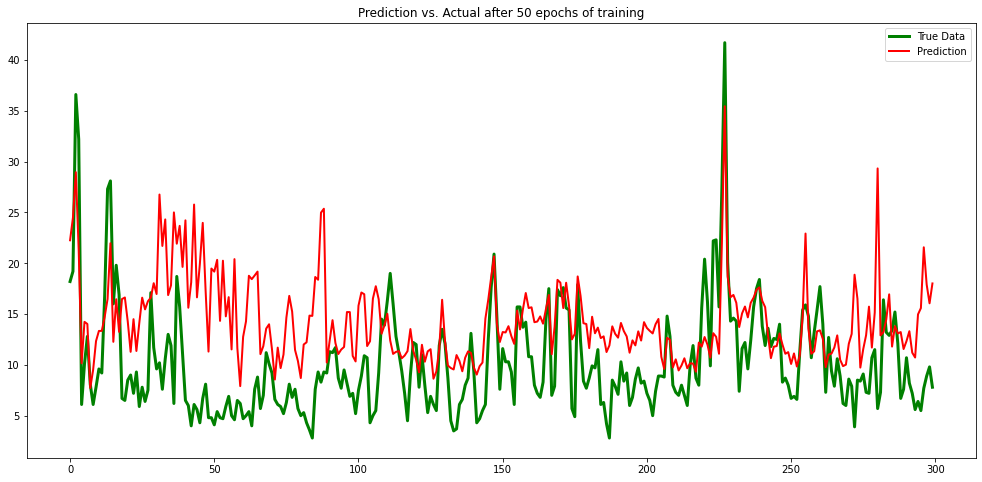

In [ ]:
plot_predicted(inv_yhat2[:300,], inv_y2[:300,])